Ridge regression
---

Exercise - Basic feature engineering for the house prices data
---

> **Exercise**: (A) load the house prices data from `house-prices.csv` (B) plot the distribution of the continuous variables using histograms: you should see that many have a skewed one (C) create a `preprocess(df)` function which performs (C.1) one-hot encoding (C.2) fill missing values (C.3) apply a **log-transform** to every continuous feature and (C.4) add their **polynomial features** of degree 2, 3 and 0.5 (square root). Finally (D) create the X/y numpy arrays - use the `np.log10()` of the sale price as the target variable.

**Hint**: The logarithm of zero doesn't exist, so we have to make sure that there are no zero values in the continuous columns when applying the log-transform. To achieve this, we can use `np.log(x+1)` (or simply `np.log1p(x)` which is equivalent) which will leave zero values untransformed i.e. `log(1)=0`

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
%matplotlib inline
import matplotlib.pyplot as plt

In [29]:
# (A) Load the data
data_df = pd.read_csv("data/house-prices.csv")

In [30]:
# Continuous features from the documentation
continuous = [
    'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
    'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
    'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
    '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val']

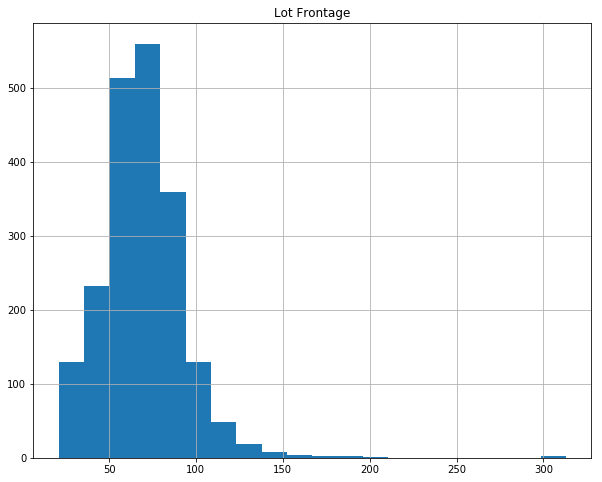

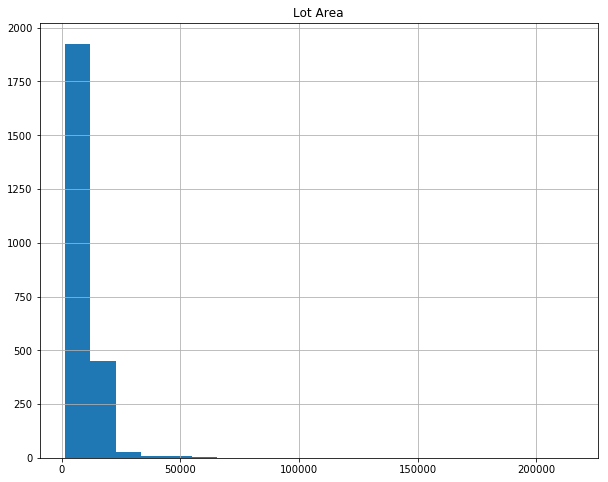

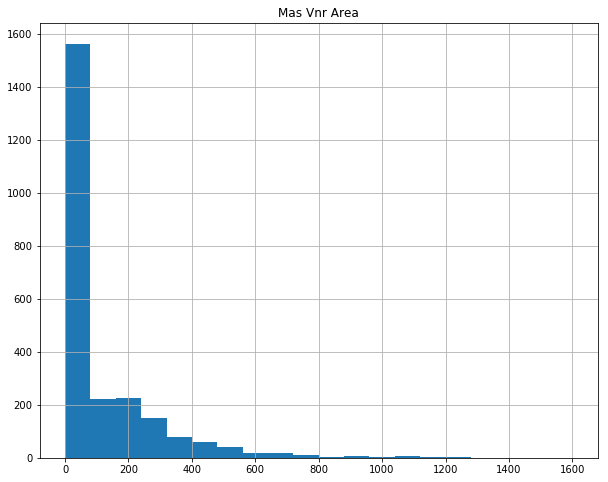

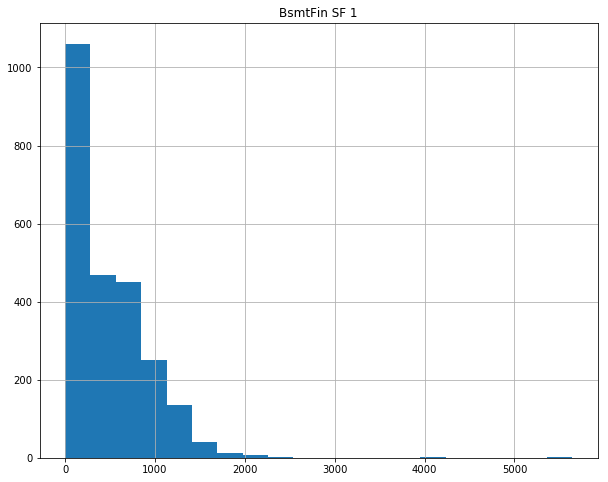

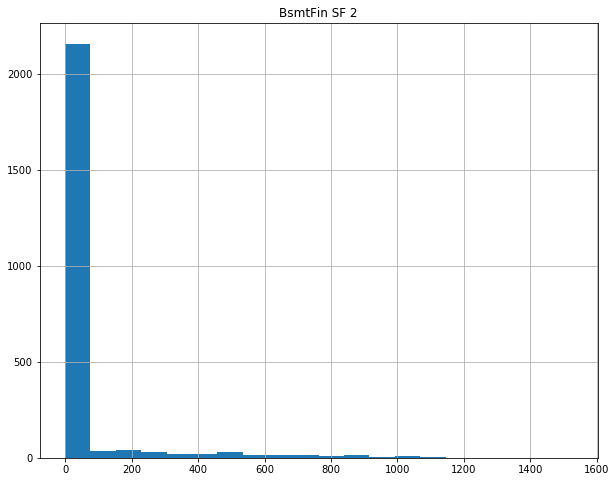

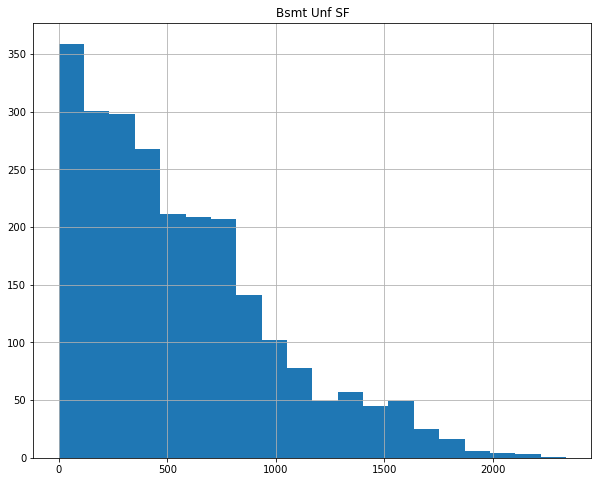

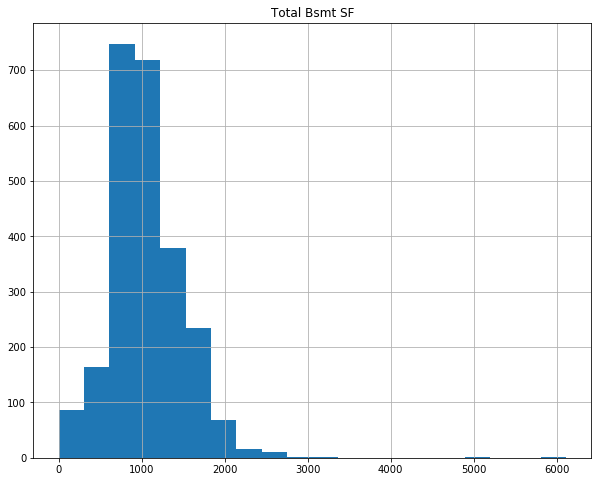

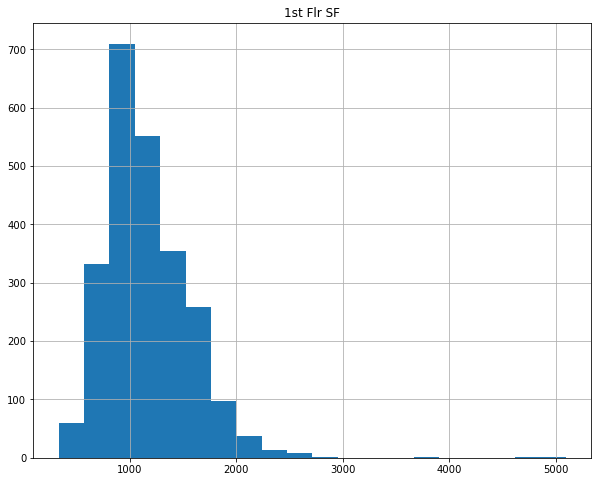

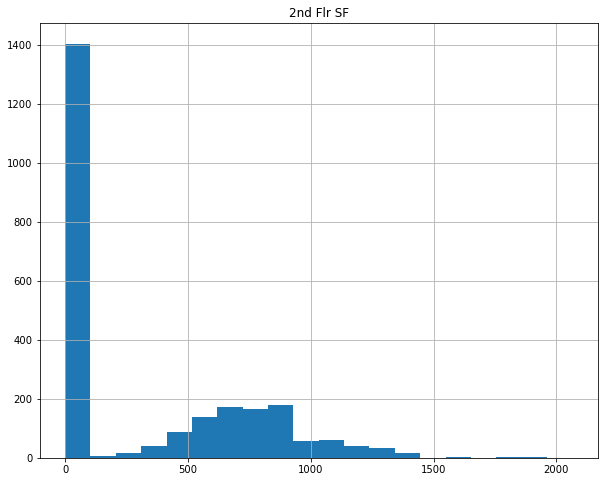

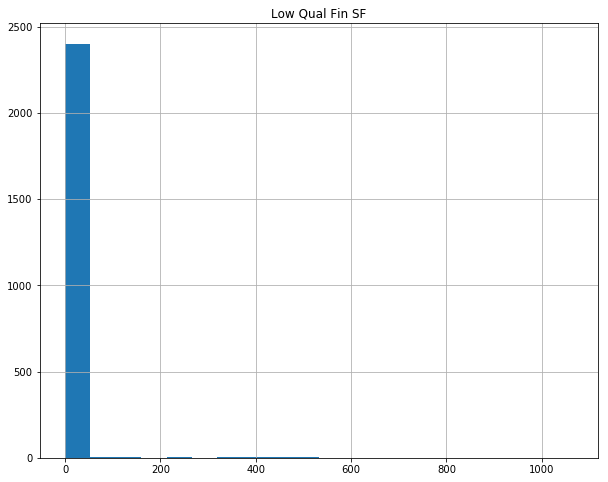

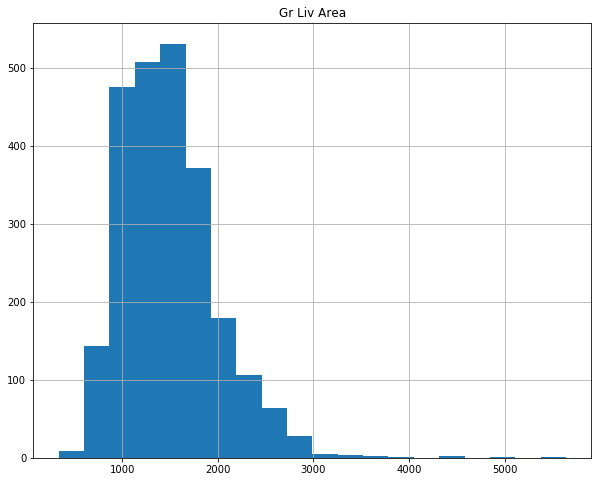

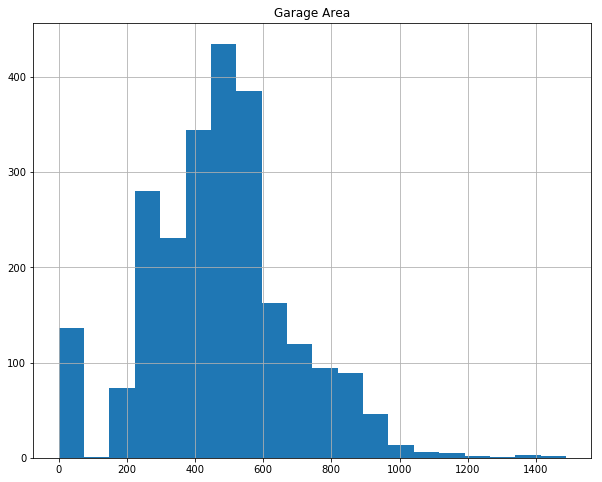

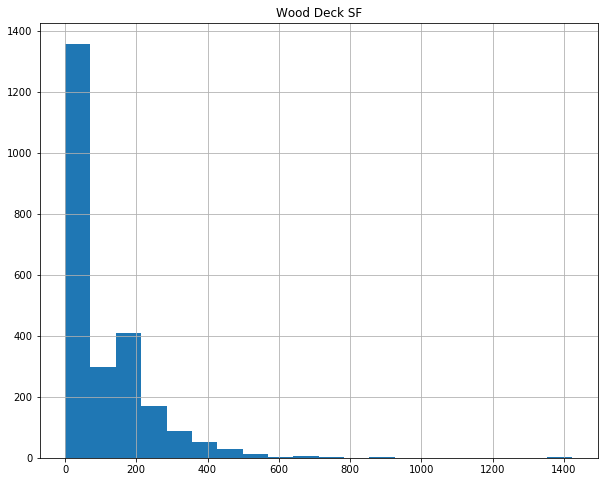

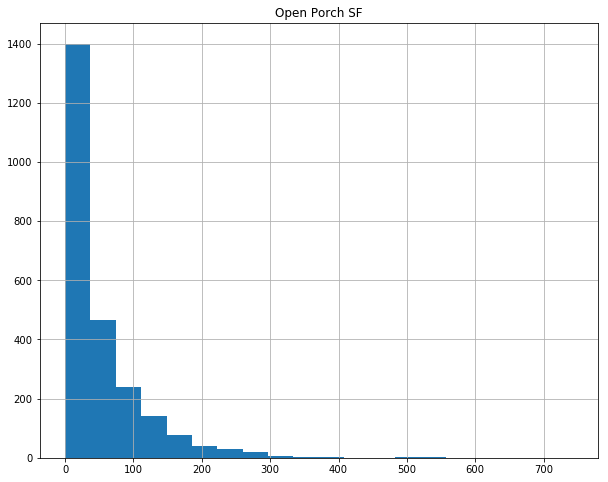

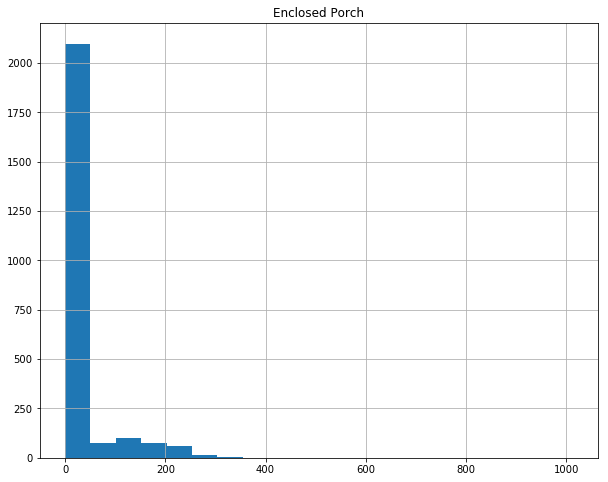

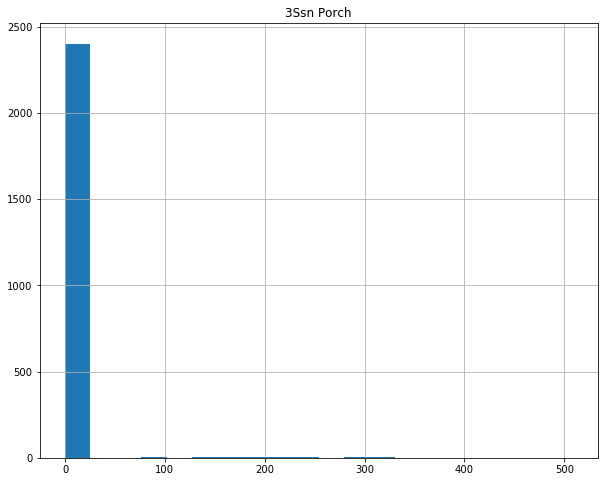

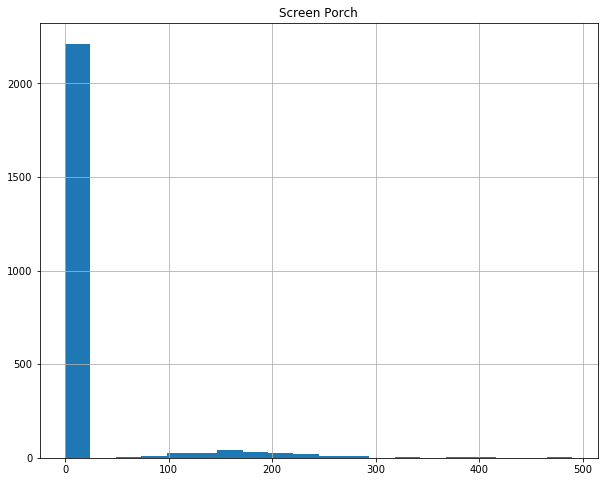

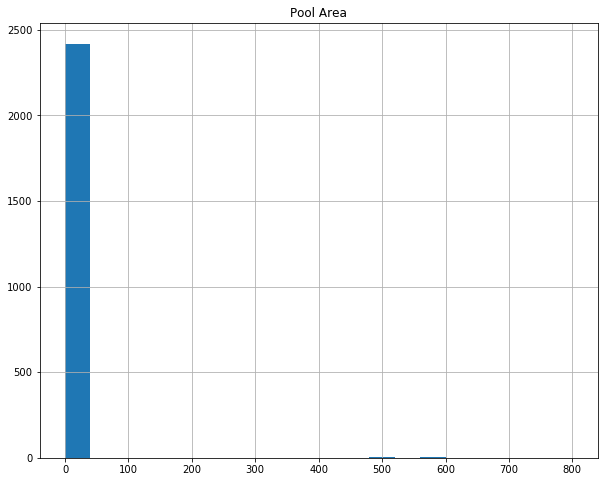

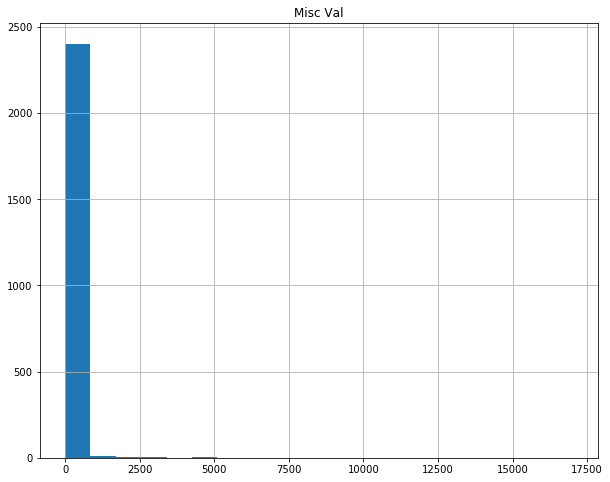

In [39]:
# (B) Plot the distribution of the continuous variables using histograms
for c in data_df[continuous]:
    data_df[[c]].hist(figsize=(10,8), bins=20)
    plt.show()

In [40]:
# (C) Preprocessing function
def preprocess(df):
    # Work on a copy
    df = df.copy()
    
    # (C.1) One-hot encoding
    df = pd.get_dummies(df, dummy_na = True)
    
    # (C.2) Fill missing values
    for c in df.columns:
        df[c] = df[c].fillna(df[c].median())
    
    # (C.3) Apply log-transform
    df[continuous] = np.log1p(df[continuous])
    
    # (C.4) Add polynomial features
    for c in continuous:
        for d in [.5, 2, 3]:
            name = '{}**{}'.format(c, d)
            df[name] = df[c]**d
            
    return df

preprocessed_df = preprocess(data_df)
preprocessed_df.head()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,3Ssn Porch**3,Screen Porch**0.5,Screen Porch**2,Screen Porch**3,Pool Area**0.5,Pool Area**2,Pool Area**3,Misc Val**0.5,Misc Val**2,Misc Val**3
0,484,528275070,60,4.234107,9.082052,7,5,2000,2000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2586,535305120,20,4.330733,9.227296,6,6,1951,1951,6.259581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2289,923228250,160,3.091042,7.601902,4,5,1970,1970,4.394449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,142,535152150,20,4.262680,9.264165,5,5,1959,1959,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2042,903475060,190,4.110874,9.222368,7,4,1910,1950,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# (D) Create X, y
X = preprocessed_df.drop('SalePrice', axis=1).values
y = np.log10(preprocessed_df.SalePrice).values

Exercise - Tune Ridge regression
---

> **Exercise**: Fit a ridge regression model and tune its alpha value using grid search. Use the train/test set methodology with a 50/50 split. Print the optimal alpha value and the test MSE/MAE scores.

**Hint**: Don't forget to standardize the input data.

In [42]:
# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=0)

print('Train:', X_tr.shape, y_tr.shape)
print('Test:', X_te.shape, y_te.shape)

Train: (1215, 404) (1215,)
Test: (1215, 404) (1215,)


In [43]:
# Standardize features
scaler = StandardScaler()
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

In [37]:
# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-1, 4, num=100):
    # Create and fit ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr_rescaled, y_tr)
    
    # Save model and its performance on train/test sets
    gs_results.append({
        'alpha': alpha,
        'train_mse': MSE(y_tr, ridge.predict(X_tr_rescaled)),
        'train_mae': MAE(10**y_tr, 10**ridge.predict(X_tr_rescaled)),
        'test_mse': MSE(y_te, ridge.predict(X_te_rescaled)),
        'test_mae': MAE(10**y_te, 10**ridge.predict(X_te_rescaled)),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,alpha,test_mae,test_mse,train_mae,train_mse
0,0.100000,15301.834238,0.004821,10517.035663,0.001279
1,0.112332,15290.058676,0.004811,10520.623780,0.001279
2,0.126186,15277.963804,0.004800,10524.386869,0.001280
3,0.141747,15265.700153,0.004788,10528.467221,0.001281
4,0.159228,15253.537456,0.004775,10532.739988,0.001282


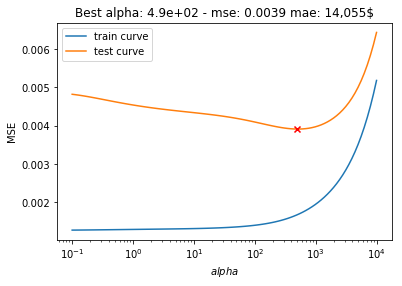

In [46]:
# Plot the validation curves
plt.semilogx(gs_results['alpha'], gs_results['train_mse'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['test_mse'], label='test curve')

# Mark best alpha value
best_result = gs_results.loc[gs_results.test_mse.idxmin()]

plt.scatter(best_result.alpha, best_result.test_mse, marker='x', c='red', zorder=10)


plt.title('Best alpha: {:.1e} - mse: {:.4f} mae: {:,.0f}$'.format(
    best_result.alpha,
    best_result.test_mse,
    best_result.test_mae))

plt.xlabel('$alpha$')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [38]:
# Group results by alpha value
gb_alpha = gs_results.groupby('alpha')

# Compute train/test mean scores with std
mean_tr = gb_alpha.train_mse.mean()
mean_te = gb_alpha.test_mse.mean()
std_tr = gb_alpha.train_mse.std()
std_te = gb_alpha.test_mse.std()
alphas = mean_tr.index.values

# Get entry with the best mean test MSE
best_alpha = mean_te.idxmin()
best_result = gb_alpha.get_group(best_alpha)

# Print the details
print('Best alpha: {:.1e}'.format(best_alpha))
print('Test MSE: {:.4f}'.format(best_result.test_mse.mean()))
print('Test MAE: {:,.0f}$'.format(best_result.test_mae.mean()))

Best alpha: 4.9e+02
Test MSE: 0.0039
Test MAE: 14,055$


In [47]:
ridge = Ridge(alpha=best_result.alpha)
ridge.fit(X_tr_rescaled, y_tr)

features = list(preprocessed_df.columns) 
features.remove('SalePrice')

coefs_df = pd.DataFrame(
    {'feature': features,
     'coefs': ridge.coef_})

coefs_df.sort_values(by='coefs', ascending=False, inplace=True)
coefs_df.head()

,feature,coefs
5,Overall Qual,0.016557
6,Overall Cond,0.011544
379,Gr Liv Area**3,0.008600
378,Gr Liv Area**2,0.008536
17,Gr Liv Area,0.008489
